# CS-GO round winner prediction model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

try:
  from google.colab import drive
  IN_COLAB = True
  print("running in COLAB environment")
except:
  IN_COLAB = False
  print("running in LOCAL environment")


if IN_COLAB:
    df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/csgo_round_snapshots.csv")
else:
    df = pd.read_csv("csgo_round_snapshots.csv")

In [2]:
PcaNumberOfCompontents = 40
    # number of dimensions after downsizing data set using PCA

TestSize = 0.15
    # float between 0 and 1 - ratio of data that will be seperated and used as testing data in training various models

SeparateMaps = True
    # bool - decide if you want replace map column with multiple columns, one for each map

NeighboursCount = 70
    # number of neighbours in KNeighboursClassifier

Estimators = 300

MLPLayerSize = 100

## Data

Data consists of multiple numerical columns describing current state of the round including:
- time to the end of round
- total score in match
- total health and armor of players in each team (ct and t)
- total players alive in each team
- total money of each team
- players weapons and utility granades for both teams


Additionaly there are boolean column and string column that need conversion to numerical values:
- played map (string)
- if bomb was planted (boolean)

Last column contains wionner of the round which is one of the teams (CT or T). Also requires conversion to number.

In [3]:
df

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122405,15.41,11.0,14.0,de_train,True,200.0,242.0,195.0,359.0,100.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,T
122406,174.93,11.0,15.0,de_train,False,500.0,500.0,95.0,175.0,11500.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T
122407,114.93,11.0,15.0,de_train,False,500.0,500.0,495.0,475.0,1200.0,...,4.0,3.0,5.0,1.0,0.0,0.0,5.0,0.0,0.0,T
122408,94.93,11.0,15.0,de_train,False,500.0,500.0,495.0,475.0,1200.0,...,5.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,T


In [4]:
df.keys()

Index(['time_left', 'ct_score', 't_score', 'map', 'bomb_planted', 'ct_health',
       't_health', 'ct_armor', 't_armor', 'ct_money', 't_money', 'ct_helmets',
       't_helmets', 'ct_defuse_kits', 'ct_players_alive', 't_players_alive',
       'ct_weapon_ak47', 't_weapon_ak47', 'ct_weapon_aug', 't_weapon_aug',
       'ct_weapon_awp', 't_weapon_awp', 'ct_weapon_bizon', 't_weapon_bizon',
       'ct_weapon_cz75auto', 't_weapon_cz75auto', 'ct_weapon_elite',
       't_weapon_elite', 'ct_weapon_famas', 't_weapon_famas',
       'ct_weapon_g3sg1', 't_weapon_g3sg1', 'ct_weapon_galilar',
       't_weapon_galilar', 'ct_weapon_glock', 't_weapon_glock',
       'ct_weapon_m249', 't_weapon_m249', 'ct_weapon_m4a1s', 't_weapon_m4a1s',
       'ct_weapon_m4a4', 't_weapon_m4a4', 'ct_weapon_mac10', 't_weapon_mac10',
       'ct_weapon_mag7', 't_weapon_mag7', 'ct_weapon_mp5sd', 't_weapon_mp5sd',
       'ct_weapon_mp7', 't_weapon_mp7', 'ct_weapon_mp9', 't_weapon_mp9',
       'ct_weapon_negev', 't_weapon_negev',

map
de_inferno     23811
de_dust2       22144
de_nuke        19025
de_mirage      18576
de_overpass    14081
de_train       13491
de_vertigo     11137
de_cache         145
Name: count, dtype: int64


Text(0, 0.5, 'Count')

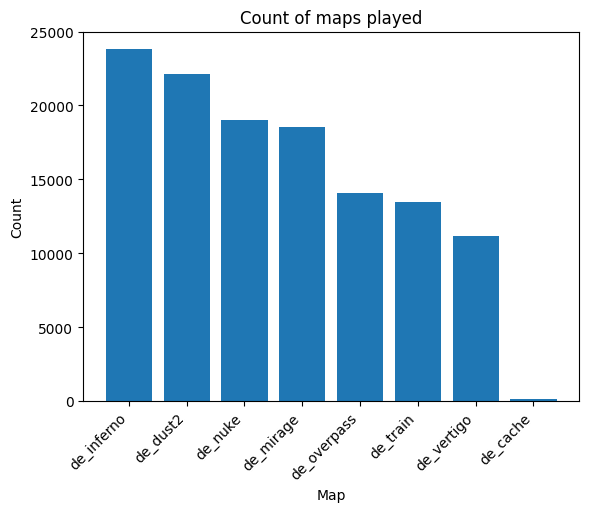

In [5]:

counts = df['map'].value_counts()
print(counts)
total = counts.sum()
percentages = counts / total * 100

plt.bar(counts.index, counts.values)

plt.xticks(rotation=45, ha='right')
plt.title('Count of maps played')
plt.xlabel('Map')
plt.ylabel('Count')

In [6]:
df.groupby('map')['map'].count()

map
de_cache         145
de_dust2       22144
de_inferno     23811
de_mirage      18576
de_nuke        19025
de_overpass    14081
de_train       13491
de_vertigo     11137
Name: map, dtype: int64

In [7]:
df.groupby('map')['map'].count().values

array([  145, 22144, 23811, 18576, 19025, 14081, 13491, 11137],
      dtype=int64)

In [8]:
df.groupby('map')['map'].count().values.reshape(-1, 1)

array([[  145],
       [22144],
       [23811],
       [18576],
       [19025],
       [14081],
       [13491],
       [11137]], dtype=int64)

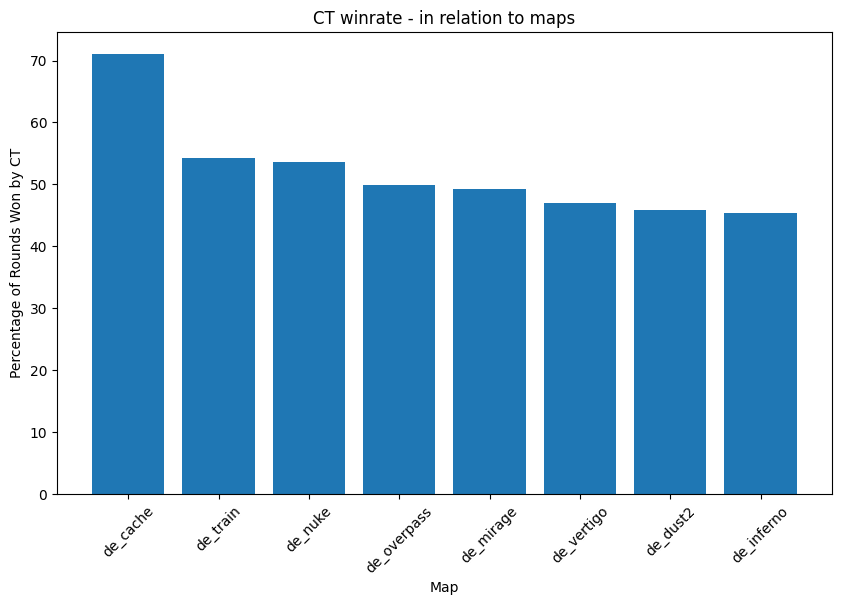

In [9]:
map_win_pct = df.groupby(['map', 'round_winner'])['round_winner'].count().unstack() / df.groupby('map')['map'].count().values.reshape(-1, 1)
ct_win_pct = map_win_pct['CT']*100

ct_win_pct = ct_win_pct.sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.bar(ct_win_pct.index, ct_win_pct)
plt.xticks(rotation=45)

plt.xlabel('Map')
plt.ylabel('Percentage of Rounds Won by CT')
plt.title('CT winrate - in relation to maps')
plt.show()

## following elements need to be converted to numbers:


| map      | bomb_planted | round_winner |
|----------|--------------|--------------|
| de_dust2 | False        | CT           |

Additionaly map can be converted to multiple columns, where each one conatins binary value.

In [10]:
# changing strings to nubmers

bool_to_numbers = {
    'False': 0,
    'True': 1
}

team_to_number = {
    'CT': 0,
    'T': 1
}

map_to_number = {
    'de_cache': 1,
    'de_dust2': 2,
    'de_inferno': 3,
    'de_mirage': 4,
    'de_nuke': 5,
    'de_overpass': 6,
    'de_train': 7,
    'de_vertigo': 8
}

if(SeparateMaps):
    mapColumns = pd.get_dummies(df['map'], dtype=int)
    df = df.drop('map', axis=1)
    df = pd.concat([df, mapColumns], axis=1)
else:
    df['map'] = df['map'].replace(map_to_number)

df['bomb_planted'] = df['bomb_planted'].replace(bool_to_numbers)
df['round_winner'] = df['round_winner'].replace(team_to_number)

attrToIndex = {attr: index for index, attr in enumerate(df.keys())}
print(attrToIndex)

{'time_left': 0, 'ct_score': 1, 't_score': 2, 'bomb_planted': 3, 'ct_health': 4, 't_health': 5, 'ct_armor': 6, 't_armor': 7, 'ct_money': 8, 't_money': 9, 'ct_helmets': 10, 't_helmets': 11, 'ct_defuse_kits': 12, 'ct_players_alive': 13, 't_players_alive': 14, 'ct_weapon_ak47': 15, 't_weapon_ak47': 16, 'ct_weapon_aug': 17, 't_weapon_aug': 18, 'ct_weapon_awp': 19, 't_weapon_awp': 20, 'ct_weapon_bizon': 21, 't_weapon_bizon': 22, 'ct_weapon_cz75auto': 23, 't_weapon_cz75auto': 24, 'ct_weapon_elite': 25, 't_weapon_elite': 26, 'ct_weapon_famas': 27, 't_weapon_famas': 28, 'ct_weapon_g3sg1': 29, 't_weapon_g3sg1': 30, 'ct_weapon_galilar': 31, 't_weapon_galilar': 32, 'ct_weapon_glock': 33, 't_weapon_glock': 34, 'ct_weapon_m249': 35, 't_weapon_m249': 36, 'ct_weapon_m4a1s': 37, 't_weapon_m4a1s': 38, 'ct_weapon_m4a4': 39, 't_weapon_m4a4': 40, 'ct_weapon_mac10': 41, 't_weapon_mac10': 42, 'ct_weapon_mag7': 43, 't_weapon_mag7': 44, 'ct_weapon_mp5sd': 45, 't_weapon_mp5sd': 46, 'ct_weapon_mp7': 47, 't_weap

In [11]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_features, columns=df.columns)



{'whiskers': [<matplotlib.lines.Line2D at 0x1de751cca90>,
 'caps': [<matplotlib.lines.Line2D at 0x1de751ccfd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1de751cc7f0>,
 'medians': [<matplotlib.lines.Line2D at 0x1de751cd510>,
 'fliers': [<matplotlib.lines.Line2D at 0x1de751cd7b0>,
 'means': []}

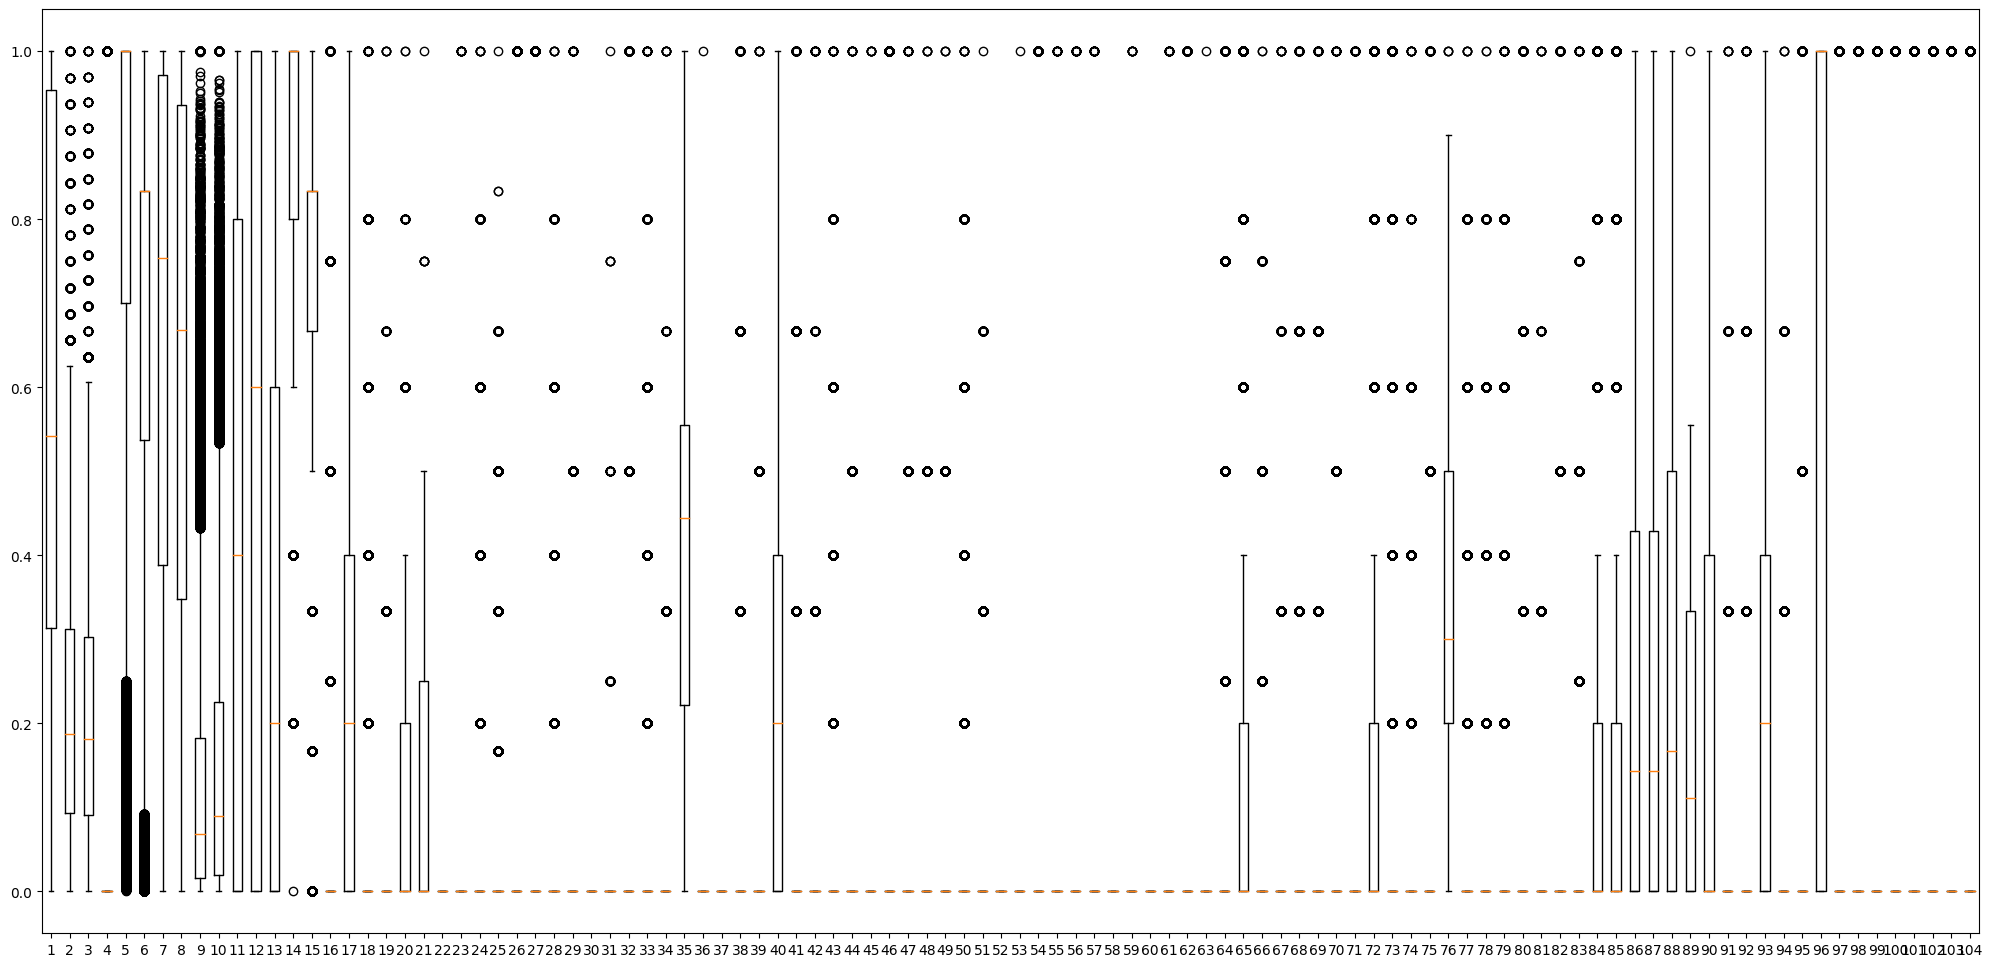

In [12]:
fig, ax = plt.subplots(figsize=(25,12))

ax.boxplot(scaled_df.to_numpy())

In [13]:
from sklearn.ensemble import IsolationForest

IF = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto')
IF.fit(scaled_df)

IsolationForest()

In [14]:
if_results = IF.predict(scaled_df)  
scaled_df_without_outliers = scaled_df[if_results==1]
outliers = scaled_df[if_results==-1]

class_results = scaled_df_without_outliers['round_winner']
scaled_df_without_outliers = scaled_df_without_outliers.drop('round_winner',axis=1)

In [15]:
print(scaled_df.shape)
print(scaled_df_without_outliers.shape)
print(class_results.shape)
print(max(scaled_df_without_outliers.to_numpy()[:,0]))

(122410, 104)
(121926, 103)
(121926,)
0.9999999999999999


In [16]:
# check missing data
missing_data = df.isnull()
print(missing_data.sum().sum())

0


In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=PcaNumberOfCompontents)
pca.fit(scaled_df_without_outliers)

scaled_df_without_outliers_pca = pca.transform(scaled_df_without_outliers)
print(scaled_df_without_outliers_pca.shape) 
print(pca.explained_variance_ratio_)

(121926, 40)
[0.21897807 0.11856683 0.09595113 0.0614915  0.05522366 0.04991041
 0.04152432 0.03645266 0.031227   0.02660651 0.02420089 0.02037024
 0.01916235 0.01676328 0.01383391 0.01278183 0.01017575 0.00972982
 0.00862228 0.00718803 0.00697269 0.00657944 0.00612314 0.00579082
 0.00528698 0.00514119 0.00507974 0.00442989 0.00423683 0.0041824
 0.00407618 0.00378149 0.00363835 0.00350598 0.00313183 0.00282773
 0.00256152 0.00248533 0.00244576 0.00235286]


# Training and evaluating models

## preparation:

In [35]:
from sklearn.model_selection import train_test_split

# classifiers:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

#crossvalidator:
from sklearn.model_selection import cross_validate

# divide data:
x_scaled_train, x_scaled_test, y_scaled_train, y_scaled_test = train_test_split(scaled_df_without_outliers_pca, class_results, test_size=TestSize, shuffle=True, random_state=None, stratify=class_results)



In [42]:
raise AssertionError("End of data preparation. Next cells contain time consuming functions!")

AssertionError: End of data preparation. Next cells contain time consuming functions!

## KNeighboursClassifier method:

In [40]:
neighboursArray = [10, 30, 100, 300] # tested hiperparameters

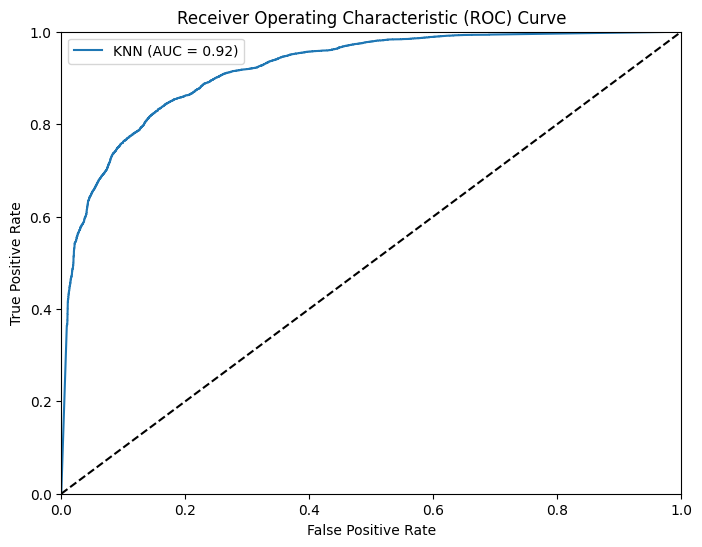

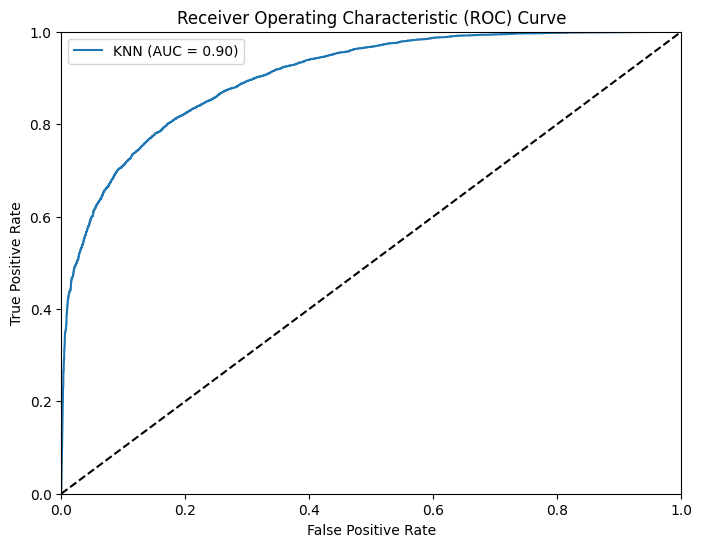

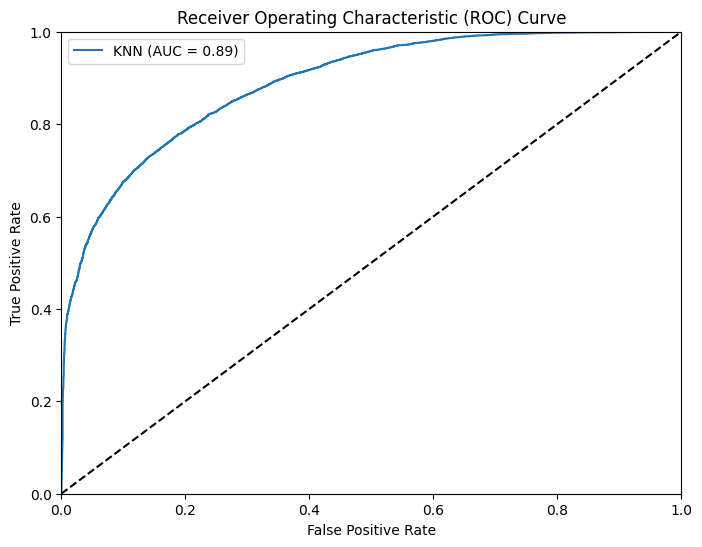

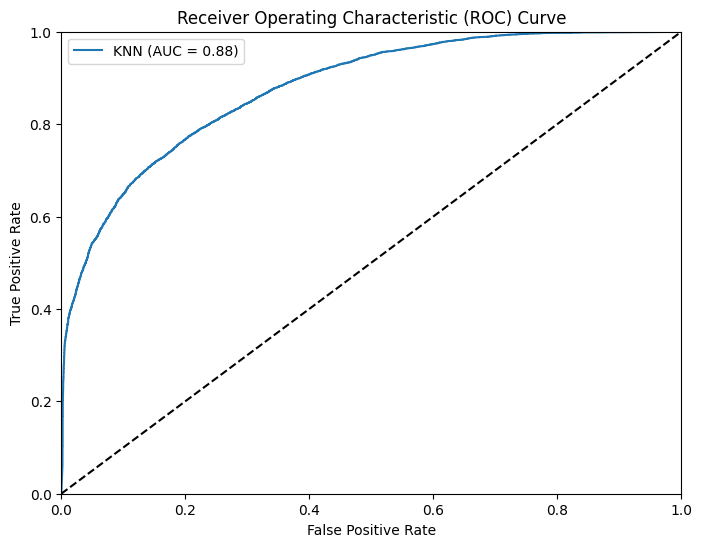

[(10, 0.8372894333843798),
 (30, 0.8137169109604026),
 (100, 0.7939728724567928),
 (300, 0.7824327280682564)]

In [ ]:
knnscores = []

for NeighboursCount in neighboursArray:
    knn = KNeighborsClassifier(n_neighbors=NeighboursCount, weights='distance', algorithm='ball_tree')
    knn.fit(x_scaled_train,y_scaled_train)

    knn_y_pred = knn.predict_proba(x_scaled_test)[:, 1]
    knn_fpr, knn_tpr, _ = roc_curve(y_scaled_test, knn_y_pred)
    knn_auc = roc_auc_score(y_scaled_test, knn_y_pred)

    plt.figure(figsize=(8, 6))
    plt.plot(knn_fpr, knn_tpr, label=f'KNN (AUC = {knn_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    score = knn.score(x_scaled_test,y_scaled_test)
    knnscores.append((NeighboursCount, score))

knnscores

#### crossvalidation of KNN:

In [36]:
knn = KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm='ball_tree')

score_types = ['accuracy', 'precision', 'recall', 'f1']
knn_cross_scores = cross_validate(knn, x_scaled_train, y_scaled_train, cv=5, scoring=score_types)

In [37]:
print("Cross-validation scores:", knn_cross_scores)
print("Average accuracy:", np.average(knn_cross_scores['test_accuracy']))
print("Average precision:", np.average(knn_cross_scores['test_precision']))
print("Average recall:", np.average(knn_cross_scores['test_recall']))
print("Average f1:", np.average(knn_cross_scores['test_f1']))

Cross-validation scores: {'fit_time': array([0.41899896, 0.39099884, 0.38700008, 0.39099932, 0.39499974]), 'score_time': array([53.26833916, 53.04895353, 54.10285044, 54.11790824, 54.09557009]), 'test_accuracy': array([0.82347549, 0.81768622, 0.82457664, 0.82520384, 0.82612052]), 'test_precision': array([0.82947067, 0.82517483, 0.82758295, 0.83186771, 0.83199847]), 'test_recall': array([0.82295609, 0.8151022 , 0.82852276, 0.82360178, 0.82570023]), 'test_f1': array([0.82620054, 0.82010758, 0.82805259, 0.82771411, 0.82883739])}
Average accuracy: 0.8234125424642869
Average precision: 0.8292189262156121
Average recall: 0.8231766109867271
Average f1: 0.826182441312082


Result of learning without dividing map column with values between 0 and 1 representing maps:

    0.7997264770240701

    0.7967084039586637

    0.8017495899398579
    
Result of learning with dividing each map to separate 0 or 1 column:

    0.8035332199484282

    0.8089063953170305

    0.8106234305055137

## RandomForestClassifier method:

In [41]:
esitimatorsArray = [300] 
# tested hiperparameters were 100, 300, 1000, 3000
# higher values got slightly beter scores, but added significantly more computation time
rfc_scores = []

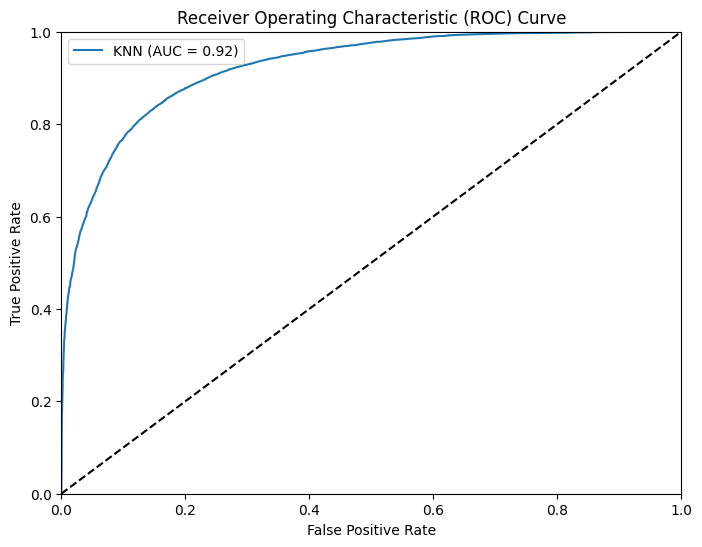

[(300, 0.8418780061215566)]

In [ ]:
for Estimators in esitimatorsArray:
    rfc = RandomForestClassifier(n_estimators=Estimators, max_features='sqrt',max_depth=None, criterion='gini')
    rfc.fit(x_scaled_train, y_scaled_train)


    rfc_y_pred = rfc.predict_proba(x_scaled_test)[:, 1]
    rfc_fpr, rfc_tpr, _ = roc_curve(y_scaled_test, rfc_y_pred)
    rfc_auc = roc_auc_score(y_scaled_test, rfc_y_pred)

    plt.figure(figsize=(8, 6))
    plt.plot(rfc_fpr, rfc_tpr, label=f'KNN (AUC = {rfc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


    score = rfc.score(x_scaled_test,y_scaled_test)
    rfc_scores.append((Estimators, score))

rfc_scores

#### Crossvalidation of RandomForestClassifier:

In [38]:
rfc = RandomForestClassifier(n_estimators=Estimators, max_features='sqrt',max_depth=None, criterion='gini')

score_types = ['accuracy', 'precision', 'recall', 'f1']
rfc_cross_scores = cross_validate(rfc, x_scaled_train, y_scaled_train, cv=5, scoring=score_types)

In [39]:
print("Cross-validation scores:", rfc_cross_scores)
print("Average accuracy:", np.average(rfc_cross_scores['test_accuracy']))
print("Average precision:", np.average(rfc_cross_scores['test_precision']))
print("Average recall:", np.average(rfc_cross_scores['test_recall']))
print("Average f1:", np.average(rfc_cross_scores['test_f1']))

Cross-validation scores: {'fit_time': array([217.91270113, 216.45149064, 216.05994439, 208.39744329,
       211.88065314]), 'score_time': array([1.10999846, 1.11100006, 1.11656141, 1.07400322, 1.10599875]), 'test_accuracy': array([0.83230413, 0.82419915, 0.83176533, 0.82983548, 0.82906354]), 'test_precision': array([0.85046452, 0.84121821, 0.84637965, 0.84837688, 0.845141  ]), 'test_recall': array([0.81425057, 0.8076268 , 0.81858616, 0.81120469, 0.81387207]), 'test_f1': array([0.83196365, 0.82408033, 0.83225093, 0.82937449, 0.82921186])}
Average accuracy: 0.8294335262866734
Average precision: 0.8463160530344412
Average recall: 0.8131080581161683
Average f1: 0.8293762498773998


For Estimators = 300

Result of learning without dividing map column:
    
    0.8375857338820302

    0.8338892230302367

    0.8307271733187535

Result of learning with dividing map column:

    0.8308004608547759

    0.8299141090869303

    0.8367725734250464

## MPLClassifier - best model

### hiperparameter optimisation

First, we tried to run one iteration of RandomisedSearch in order to estimate time cost.

In [ ]:
raise AssertionError("Warning. This cell takes time. Comment assertion to run!")

from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

mlp = MLPClassifier(hidden_layer_sizes=[512, 256, 128, 64])

param_dist = {
    'learning_rate_init': loguniform(0.001, 0.1),
    'alpha': loguniform(0.0001, 0.01),
    'activation': ['relu', 'logistic', 'tanh']
}

random_search = RandomizedSearchCV(mlp, param_dist, n_iter=1, cv=5)

random_search.fit(x_scaled_train, y_scaled_train)

C:\Users\ckta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ckta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ckta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ckta\AppDa

RandomizedSearchCV(cv=5,
                   estimator=MLPClassifier(hidden_layer_sizes=[512, 256, 128,
                                                               64]),
                   n_iter=1,
                   param_distributions={'activation': ['relu', 'logistic',
                                                       'tanh'],
                                        'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000242B9DEC970>,
                                        'learning_rate_init': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000242B94DB280>})

In [ ]:
print("Best Hyperparameters: ", random_search.best_params_)
print("Cross validation results: ", random_search.cv_results_)

Best Hyperparameters:  {'activation': 'logistic', 'alpha': 0.0001371806555428976, 'learning_rate_init': 0.003956071222322071}
Cross validation results:  {'mean_fit_time': array([992.12038555]), 'std_fit_time': array([8.24677599]), 'mean_score_time': array([0.86691651]), 'std_score_time': array([0.02520339]), 'param_activation': masked_array(data=['logistic'],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_alpha': masked_array(data=[0.0001371806555428976],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_learning_rate_init': masked_array(data=[0.003956071222322071],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'activation': 'logistic', 'alpha': 0.0001371806555428976, 'learning_rate_init': 0.003956071222322071}], 'split0_test_score': array([0.80299011]), 'split1_test_score': array([0.80212202]), 'split2_test_score': array([0.79344104]), 'split3_test_score': array([0.7805642

Cell was running for 80 minutes, so we decided to decrease amount of folds from 5 to 3 and run more iterations.

In [ ]:
raise AssertionError("Warning. This cell takes time. Comment assertion to run!")

from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

mlp = MLPClassifier(hidden_layer_sizes=[512, 256, 128, 64])

param_dist = {
    'learning_rate_init': loguniform(0.001, 0.1),
    'alpha': loguniform(0.0001, 0.01),
    'activation': ['relu', 'logistic', 'tanh']
}


random_search = RandomizedSearchCV(mlp, param_dist, n_iter=9, cv=3)

random_search.fit(x_scaled_train, y_scaled_train)


C:\Users\ckta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ckta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ckta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ckta\AppDa

RandomizedSearchCV(cv=3,
                   estimator=MLPClassifier(hidden_layer_sizes=[512, 256, 128,
                                                               64]),
                   n_iter=9,
                   param_distributions={'activation': ['relu', 'logistic',
                                                       'tanh'],
                                        'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000245A4C267A0>,
                                        'learning_rate_init': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000245A4BEE1D0>})

In [ ]:
print("Best Hyperparameters: ", random_search.best_params_)
print("Cross validation results: ", random_search.cv_results_)

Best Hyperparameters:  {'activation': 'relu', 'alpha': 0.00010320886634229802, 'learning_rate_init': 0.0025634596876714837}
Cross validation results:  {'mean_fit_time': array([878.15183258, 385.2487038 , 199.692077  , 419.29685243,
       413.48670769, 294.59242948, 359.78329261, 839.71976479,
       212.65346169]), 'std_fit_time': array([  5.71254064,  80.92430521,  16.71864253,  74.55163374,
         7.62665268, 168.07750978,  38.76707261, 114.23415345,
        10.92209367]), 'mean_score_time': array([1.45869613, 1.14766645, 0.46250645, 1.28551714, 0.46800049,
       0.85500026, 1.2683328 , 1.59533207, 0.46433369]), 'std_score_time': array([0.01746283, 0.02499762, 0.00494807, 0.08154978, 0.00565774,
       0.37848689, 0.18437375, 0.01730792, 0.00612856]), 'param_activation': masked_array(data=['logistic', 'relu', 'tanh', 'relu', 'tanh', 'relu',
                   'relu', 'logistic', 'tanh'],
             mask=[False, False, False, False, False, False, False, False,
                  

### cross validation of best mlp model:

In [22]:
from sklearn.model_selection import cross_validate
mlp = MLPClassifier(hidden_layer_sizes=[512, 256, 128, 64],activation= 'relu', alpha= 0.00010320886634229802, learning_rate_init= 0.0025634596876714837)

score_types = ['accuracy', 'precision', 'recall', 'f1']
scores = cross_validate(mlp, x_scaled_train, y_scaled_train, cv=5, scoring=score_types)


In [29]:
print("Cross-validation scores:", scores)
print("Average accuracy:", np.average(scores['test_accuracy']))
print("Average precision:", np.average(scores['test_precision']))
print("Average recall:", np.average(scores['test_recall']))
print("Average f1:", np.average(scores['test_f1']))

Cross-validation scores: {'fit_time': array([547.81214547, 565.70176506, 551.05594707, 392.56980348,
       343.78021002]), 'score_time': array([0.85599947, 0.78900003, 0.6919992 , 0.62499905, 0.77500153]), 'test_accuracy': array([0.85695677, 0.85661907, 0.85048487, 0.85477879, 0.85217349]), 'test_precision': array([0.86346687, 0.86407209, 0.84734884, 0.85602563, 0.8551685 ]), 'test_recall': array([0.85456094, 0.85295231, 0.86202328, 0.85975206, 0.85484481]), 'test_f1': array([0.85899082, 0.85847619, 0.85462307, 0.8578848 , 0.85500663])}
Average accuracy: 0.8542025997410196
Average precision: 0.8572163838927512
Average recall: 0.856826680078318
Average f1: 0.8569963009183337


### ROC curve for best mlp model:

In [31]:
mlp = MLPClassifier(hidden_layer_sizes=[512, 256, 128, 64],activation= 'relu', alpha= 0.00010320886634229802, learning_rate_init= 0.0025634596876714837)
mlp.fit(x_scaled_train,y_scaled_train)

MLPClassifier(alpha=0.00010320886634229802,
              hidden_layer_sizes=[512, 256, 128, 64],
              learning_rate_init=0.0025634596876714837)

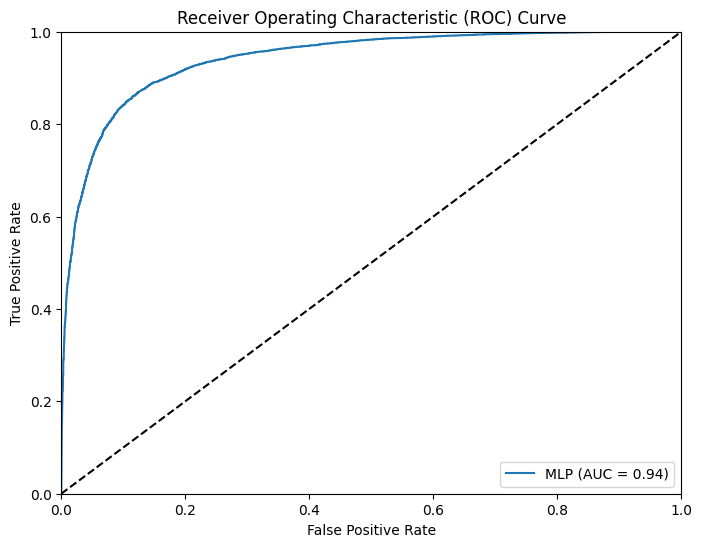

In [33]:
mlp_y_pred = mlp.predict_proba(x_scaled_test)[:, 1]
mlp_fpr, mlp_tpr, _ = roc_curve(y_scaled_test, mlp_y_pred)
mlp_auc = roc_auc_score(y_scaled_test, mlp_y_pred)

plt.figure(figsize=(8, 6))
plt.plot(mlp_fpr, mlp_tpr, label=f'MLP (AUC = {mlp_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [34]:
mlp.score(x_scaled_test, y_scaled_test)

#previous 0.7856204858831254
#previous 0.8781154350677743

0.8718355295532834

## voting classifier

In [43]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(
    estimators=[('MLP', mlp), ('KNN', knn), ('RFC', rfc)],
    voting='hard'
)

voting_model.fit(x_scaled_train, y_scaled_train)


VotingClassifier(estimators=[('MLP',
                              MLPClassifier(alpha=0.00010320886634229802,
                                            hidden_layer_sizes=[512, 256, 128,
                                                                64],
                                            learning_rate_init=0.0025634596876714837)),
                             ('KNN',
                              KNeighborsClassifier(algorithm='ball_tree',
                                                   n_neighbors=10,
                                                   weights='distance')),
                             ('RFC', RandomForestClassifier(n_estimators=300))])

In [44]:
score_types = ['accuracy', 'precision', 'recall', 'f1']
voting_cross_scores = cross_validate(voting_model, x_scaled_train, y_scaled_train, cv=5, scoring=score_types)

In [45]:
print("Cross-validation scores:", voting_cross_scores)
print("Average accuracy:", np.average(voting_cross_scores['test_accuracy']))
print("Average precision:", np.average(voting_cross_scores['test_precision']))
print("Average recall:", np.average(voting_cross_scores['test_recall']))
print("Average f1:", np.average(voting_cross_scores['test_f1']))

Cross-validation scores: {'fit_time': array([ 741.64639258,  999.20045018,  664.62171817,  788.98795629,
       1000.49825335]), 'score_time': array([54.1500361 , 52.16700006, 55.65300679, 53.16456223, 55.17500019]), 'test_accuracy': array([0.85063682, 0.84455809, 0.85318666, 0.85159454, 0.85260771]), 'test_precision': array([0.86075705, 0.85792243, 0.86382979, 0.86129063, 0.86270155]), 'test_recall': array([0.84348978, 0.833081  , 0.84527302, 0.84498912, 0.84547691]), 'test_f1': array([0.85203594, 0.84531925, 0.85445066, 0.853062  , 0.85400239])}
Average accuracy: 0.8505167636907854
Average precision: 0.8613002913616044
Average recall: 0.8424619655968364
Average f1: 0.8517740494019297


In [47]:
# voting_y_pred = voting_model.predict_proba(x_scaled_test)[:, 1]
# voting_fpr, voting_tpr, _ = roc_curve(y_scaled_test, voting_y_pred)
# voting_auc = roc_auc_score(y_scaled_test, voting_y_pred)

# plt.figure(figsize=(8, 6))
# plt.plot(voting_fpr, voting_tpr, label=f'voting algorithm (AUC = {voting_auc:.2f})')
# plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend()
# plt.show()

# AttributeError: predict_proba is not available when voting='hard'

### Other tests and evaluations:

Here are some models that were tested without cross validation eriler in development and other legacy stuff:

In [ ]:
knn = KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm='ball_tree')
knn.fit(x_scaled_train,y_scaled_train)

y_pred_knn = knn.predict(x_scaled_test)


In [ ]:
from sklearn.metrics import classification_report
print('knn accuracy: ', accuracy_score(y_scaled_test, y_pred_knn))
print('knn precision: ', precision_score(y_scaled_test, y_pred_knn))
print('knn recall: ', recall_score(y_scaled_test, y_pred_knn))
print('knn f1-score: ', f1_score(y_scaled_test, y_pred_knn))

print(classification_report(y_scaled_test, y_pred_knn))


knn accuracy:  0.7927209137111317
knn precision:  0.8112910481331534
knn recall:  0.7732875978132705
knn f1-score:  0.7918335985950278
              precision    recall  f1-score   support

         0.0       0.78      0.81      0.79      8970
         1.0       0.81      0.77      0.79      9329

    accuracy                           0.79     18299
   macro avg       0.79      0.79      0.79     18299
weighted avg       0.79      0.79      0.79     18299



##### pca=40 n=40

knn accuracy:  0.8031371263048587

knn precision:  0.817677104152787

knn recall:  0.7897897897897898

knn f1-score:  0.8034915439170758


##### pca=25 n=40

knn accuracy:  0.783441237792165

knn precision:  0.8047418214977773

knn recall:  0.7596298687325156

knn f1-score:  0.7815353960259036

##### pca=40 n=70

                   precision    recall  f1-score   support

              0.0       0.78      0.81      0.79      8970
              1.0       0.81      0.77      0.79      9329
         accuracy          -         -      0.79     18299
        macro avg       0.79      0.79      0.79     18299
     weighted avg       0.79      0.79      0.79     18299


In [ ]:
confusion_matrix(y_scaled_test, y_pred_knn)

array([[7292, 1678],
       [2115, 7214]], dtype=int64)

In [ ]:
y_pred_rfc = rfc.predict(x_scaled_test)

In [ ]:
print('rfc accuracy: ', accuracy_score(y_scaled_test, y_pred_rfc))
print('rfc precision: ', precision_score(y_scaled_test, y_pred_rfc))
print('rfc recall: ', recall_score(y_scaled_test, y_pred_rfc))
print('rfc f1-score: ', f1_score(y_scaled_test, y_pred_rfc))

print(classification_report(y_scaled_test, y_pred_rfc))


rfc accuracy:  0.8410842122520357
rfc precision:  0.8571587495828235
rfc recall:  0.8259191767606389
rfc f1-score:  0.8412490446555301
              precision    recall  f1-score   support

         0.0       0.83      0.86      0.84      8970
         1.0       0.86      0.83      0.84      9329

    accuracy                           0.84     18299
   macro avg       0.84      0.84      0.84     18299
weighted avg       0.84      0.84      0.84     18299



##### pca=40 est=default

rfc accuracy:  0.8350549270372192

rfc precision:  0.8539515042658284

rfc recall:  0.8158515658515658

rfc f1-score:  0.8344668714348399


##### pca=25 est=default

rfc accuracy:  0.8217381762317568

rfc precision:  0.8428036747192923

rfc recall:  0.7995480955455132

rfc f1-score:  0.8206062613881067

##### pca=40 est=300

                  precision    recall  f1-score   support
             0.0       0.83      0.86      0.84      8970
             1.0       0.86      0.83      0.84      9329
        accuracy                           0.84     18299
       macro avg       0.84      0.84      0.84     18299
    weighted avg       0.84      0.84      0.84     18299

In [ ]:
confusion_matrix(y_scaled_test, y_pred_rfc)

array([[7686, 1284],
       [1624, 7705]], dtype=int64)

In [ ]:
y_pred_mlp = mlp.predict(x_scaled_test)

In [ ]:
print(classification_report(y_scaled_test, y_pred_mlp))

              precision    recall  f1-score   support

         0.0       0.77      0.81      0.79      8964
         1.0       0.81      0.76      0.78      9312

    accuracy                           0.79     18276
   macro avg       0.79      0.79      0.79     18276
weighted avg       0.79      0.79      0.79     18276



# Final result:

best classifier:
- MLP

hiperparameters:
- hidden_layer_sizes = [512, 256, 128, 64]
- activation = 'relu'
- alpha = 0.00010320886634229802
- learning_rate_init = 0.0025634596876714837

crossvalidated scores:
- average accuracy: 0.8542025997410196
- average precision: 0.8572163838927512
- average recall: 0.856826680078318
- average f1: 0.856996300918333